<a href="https://colab.research.google.com/github/lisatwyw/AFib/blob/main/afib_predict_death_risks_nnsurv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brief recap

NNsurv model


# Mount drive 

In [132]:
from google.colab import drive
drive.mount('/content/drive')

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

subdir='AFib'
try:
  os.mkdir( '/content/drive/My Drive/Colab Notebooks/%s'% subdir )
except: 
  pass  
import os
try:
  os.mkdir( '/content/drive/My Drive/Colab Notebooks/%s'% subdir )
except:
  pass  
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/%s'% subdir )

#!ls death*mlp*


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install and import packages

In [2]:
%%capture

try:
  import bqplot as bq
  
except:
  !jupyter nbextension enable --py widgetsnbextension
  !pip install layout
  !pip install bqplot
  !pip install scikit-survival

  import numpy as np  
  import bqplot as bq
  
  import ipywidgets as widgets

  from ipywidgets import Button, Layout, VBox, HBox
  from ipywidgets import TwoByTwoLayout

  from IPython.display import display 

  import pandas as pd
  import sksurv
  import matplotlib.pyplot as plt
  %matplotlib inline

  !pip install tensorflow


In [3]:
from tensorflow import keras
from tensorflow.keras import layers      
   
def get_mlp_branch_v2(Xdata, DO, GA, IN, act, nunits_last, SEED, last_act, BN=0, input_layer= None, BS=None, l1=.2, l2=.01 ):        
    
    bIN = 'zeros'    
    from tensorflow.keras import layers
    from tensorflow import keras 
    
    nfeatures = Xdata['trn'].shape[1]  

    print(nfeatures)    
    if input_layer is None:
        if BS is not None:                
            input_layer=layers.Input( shape=(BS, nfeatures,) )        
        else:        
            input_layer=layers.Input( shape=(nfeatures,) )        
    
    if (l1>0) | (l2>0):    
        print('LASSO regularization applied...')
        KR=keras.regularizers.l1_l2(l1=l1, l2=l2)
        AR=keras.regularizers.l2(l2=l2)
    else:
        AR=KR=None
    l=layers.Dense( nfeatures, kernel_regularizer=KR, activity_regularizer=AR, kernel_initializer=IN, bias_initializer=bIN )( input_layer )            
    
    if BN==1:
        l=layers.BatchNormalization()(l)    
        print( 'Batch normalization')
    elif BN==2:
        print( 'Wt normalization...layer1')
        l = tfa.layers.WeightNormalization(l)        
    l=layers.Activation( act )(l)
    if DO>0:
        l=layers.Dropout( DO, seed=SEED )(l)
    
    l=layers.Dense( nfeatures//2,  kernel_regularizer=KR, activity_regularizer=AR, kernel_initializer=IN, bias_initializer=bIN, )( l )        
    if BN==1:
        l=layers.BatchNormalization()(l)        
        print( 'Batch normalization')
    elif BN==2:
        print( 'Wt normalization')
        l = tfa.layers.WeightNormalization(l)
    l=layers.Activation( act )(l)
    if DO>0:
        l=layers.Dropout( DO, seed=SEED )(l)                
        
    l=layers.Dense( nfeatures//4, kernel_regularizer=KR, activity_regularizer=AR, kernel_initializer=IN, bias_initializer=bIN, )( l )        
    if BN==1:
        print( 'Batch normalization')
        l=layers.BatchNormalization()(l)        
    elif BN==2:
        print( 'Wt normalization')
        l = tfa.layers.WeightNormalization(l)
    l=layers.Activation( act )(l)
    if DO>0:
        l=layers.Dropout( DO, seed=SEED )(l)                

    if last_act == 'sigmoid': 
        GA=1
        
    if nunits_last > 1:
        l=layers.Dense( nunits_last*GA, kernel_regularizer=KR, activity_regularizer=AR, kernel_initializer=IN, bias_initializer=bIN, )( l )   
    elif nunits_last == 1:
        l=layers.Dense( nunits_last*GA, kernel_regularizer=KR, activation = last_act, name=last_act )( l )   
        
    if nunits_last > 1:
        if BN==1:
            print( 'Batch normalization')
            l=layers.BatchNormalization()(l)        
        elif BN==2:
            print( 'Wt normalization')
            l = tfa.layers.WeightNormalization(l)
        l=layers.Activation( act )(l)
        
        if DO>0:
            l=layers.Dropout( DO, seed=SEED )(l)                
    
    if last_act == 'sigmoid':     
        l=layers.Activation('sigmoid', name='sigmoid')(l)    
    
    model=keras.Model( input_layer, l )
    return model, input_layer, l     
      

last_act='sigmoid'; n_units_last_level = 11   
  

In [119]:
import tensorflow as tf 

models = {}
filenames={}

from tensorflow.keras.models import *


# key parameter settings:
BK=2
fid=88 

filenames['death']='death_normv0_mlp_SW0.0_fa88_BK2_HeN_elu_Adam_SH1_BN1_BS64_LR0.001_LRR0.00_DE0_l10.00_l20.00_DO0.20_mse1+nph_wt1.00_0FD20_FS0_VS0.2_modeday_05-29.1best.h5'

surv_preds = {}

def readpkl( filename ):
  from pickle import load
  file=open(filename,'rb')
  dat = load(file)
  return dat
   
class mylosses( tf.keras.losses.Loss ):
    
    def __init__( self, n_intervals, name, wt, filename, reduction = keras.losses.Reduction.AUTO ):
        super().__init__( reduction=reduction, name = name)
        self.n_intervals = n_intervals
        self.wt = wt
        self.filename = filename 
        self.L1 = []
        self.L2 = []
        
    def append_losses( self, a, b ):
        self.L1.append( a ) 
        self.L2.append( b ) 
        
    def call(self, y_true, y_pred):               
        cens_uncens = 1. + y_true[:,0:n_intervals] * (y_pred-1.)
        
        #component for only uncensored individuals
        uncens = 1. - y_true[:,n_intervals:2*n_intervals] * y_pred                                                                
                
        L = wt[0]*K.sum(-K.log(K.clip(K.concatenate((cens_uncens,uncens)),K.epsilon(),None)),axis=-1)            
        L2 = wt[1]*tf.reduce_mean(K.square(y_true[:,:n_intervals] - y_pred ),axis=-1)
                
        import tensorflow.keras.backend as K        
        
        #component for all individuals
        cens_uncens = 1. + y_true[:,0:self.n_intervals] * (y_pred-1.)
        
        #component for only uncensored individuals
        uncens = 1. - y_true[:,self.n_intervals:] * y_pred                                                                
        
        L = self.wt[0]*K.sum(-K.log(K.clip(K.concatenate((cens_uncens,uncens)),K.epsilon(),None)),axis=-1)            
        L2 = self.wt[1]*tf.reduce_mean( K.square(y_true[:,:self.n_intervals] - y_pred ),axis=-1)

        if self.filename is not None:  
            a = tf.reduce_mean(L )
            b = tf.reduce_mean(L2)
            tf.print(' l1=', a, ", l2=",b , output_stream='file://' + self.filename )
        return L+L2        


for ev in ['death']:
  models[ev]=load_model(filenames[ev], custom_objects={ 'loss': mylosses( n_intervals= 72, wt=[1.0, 1.0], filename='', name='' )} )

models[ev].summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 15)]              0         
                                                                 
 dense_32 (Dense)            (None, 15)                240       
                                                                 
 batch_normalization_32 (Bat  (None, 15)               60        
 chNormalization)                                                
                                                                 
 activation_32 (Activation)  (None, 15)                0         
                                                                 
 dropout_32 (Dropout)        (None, 15)                0         
                                                                 
 dense_33 (Dense)            (None, 7)                 112       
                                                           

## Confirm that the model weights have been loaded successfully

In [17]:
models[ev].get_weights()[0]


array([[ 1.39284790e+00,  3.62569660e-01, -2.27631167e-01,
         6.34991288e-01, -2.27914736e-01, -9.60167870e-02,
        -1.08588897e-01, -7.22665548e-01,  1.13181555e+00,
         5.42276561e-01, -2.20491420e-02, -7.01015353e-01,
        -1.05537541e-01, -8.77958298e-01,  4.18284237e-01],
       [ 1.85691953e+00,  1.42090487e+00, -1.70302689e+00,
         3.28352284e+00, -7.04406142e-01, -3.56834197e+00,
        -3.22912860e+00, -2.71639848e+00,  4.14086533e+00,
         2.32356811e+00,  4.35849905e+00, -1.96694314e+00,
        -1.40784883e+00, -2.30420256e+00,  3.11208367e+00],
       [ 5.90137362e-01,  7.31817305e-01, -5.47223628e-01,
         1.31825221e+00, -4.42454726e-01, -1.62207699e+00,
        -1.51124668e+00, -1.65216863e+00,  1.57302535e+00,
         8.52717936e-01,  1.60229337e+00, -5.87061822e-01,
        -5.90616226e-01, -4.70610946e-01,  1.67375100e+00],
       [ 1.18675458e+00,  5.76747358e-01, -4.29598391e-01,
         1.36059988e+00, -4.95445549e-01, -1.48443770

In [121]:

NYRS=1
query_time_endpoint = NYRS*365 # risk prediction at the nth date

# 1,2,3,6,7,8,9,10 in TR
ev='death'
Samples ={}
sample_data_death = np.asarray( [[79,0,0,1,0,0,1,0,30,0,0,0,0,0,0], 
                                 [80,0,0,0,1,0,1,0, 0,1,0,1,0,0,0], 
                                 [82,0,0,0,0,0,2,0, 0,1,0,0,1,0,0],
                                 [92,0,0,0,0,0,1,0, 0,0,0,0,0,81,0],
                                 [43,0,0,0,0,0,2,0, 0,0,0,0,0,0,0],
                                 [73,0,0,0,0,0,2,0, 0,0,0,0,0,0,0],
                                 [62,0,0,0,0,0,2,0, 0,1,0,0,1,0,0],
                                 [81,0,0,0,0,0,2,0, 0,0,0,0,0,0,0] ])
                                  
Samples[ev]=pd.DataFrame( sample_data_death, columns=['Age', 'CCI_carcinoma', 'dementia', 'CCI_CHF', 'CCI_COPD', 'CCI_cancer','SEX', 'rx_n_90d_prior_diuretic_loop', 'rx_n_365d_prior_diuretic_loop','CCI_CVD', 'FRL_care', 'FRL_chemistry','FRL_brain', 'b4dx_age_sepsis','b4dx_age_cancer'])

Samples[ev]['Time2Event']=(np.asarray( [2071, 117, 8, 974,    1717, 1574, 3056, 164]) ).astype(int) 
Samples[ev]['Event?']=(np.asarray( [1,1,1,1, 0,0,0,0])).astype(int)
Samples[ev]['Event?']=Samples[ev]['Event?']  
Samples[ev].transpose()


,0,1,2,3,4,5,6,7
Age,79,80,82,92,43,73,62,81
CCI_carcinoma,0,0,0,0,0,0,0,0
dementia,0,0,0,0,0,0,0,0
CCI_CHF,1,0,0,0,0,0,0,0
CCI_COPD,0,1,0,0,0,0,0,0
CCI_cancer,0,0,0,0,0,0,0,0
SEX,1,1,2,1,2,2,2,2
rx_n_90d_prior_diuretic_loop,0,0,0,0,0,0,0,0
rx_n_365d_prior_diuretic_loop,30,0,0,0,0,0,0,0
CCI_CVD,0,1,1,0,0,0,1,0


In [122]:
curr_pt_data = Samples[ev].drop('Event?', axis=1) 
curr_pt_data = curr_pt_data.drop('Time2Event', axis=1) 
curr_pt_data.transpose()

yp = models[ev].predict( curr_pt_data )
mode='day'
nyrs= 6
if mode=='day':
    halflife=365.    
    breaks_list = [np.arange(0.,365.*(nyrs+.01),365.),
               np.arange(0.,365.*(nyrs+.01),365./4),
        np.arange(0.,365.*(nyrs+.01),365./12),
        np.arange(0.,365.*(nyrs+.01),365./52),
        -np.log(1-np.arange(0.0,0.96,0.05))*halflife/np.log(1.8), 
        -np.log(1-np.arange(0.0,.96,0.01))*halflife/np.log(1.8) ]

breaks_description_list = ['uniform intervals every year', 'uniform intervals every 3 months', 'uniform intervals every month',
                           'uniform intervals every week', 'increasing intervals over time, half-life 1 year', 'Dense: increasing intervals over time, half-life 1 year']

print('\n\n',breaks_description_list[BK] )
breaks=breaks_list[BK]


                  




 uniform intervals every month


Text(0.5, 1.0, 'Event within 1-year post AF Dx')

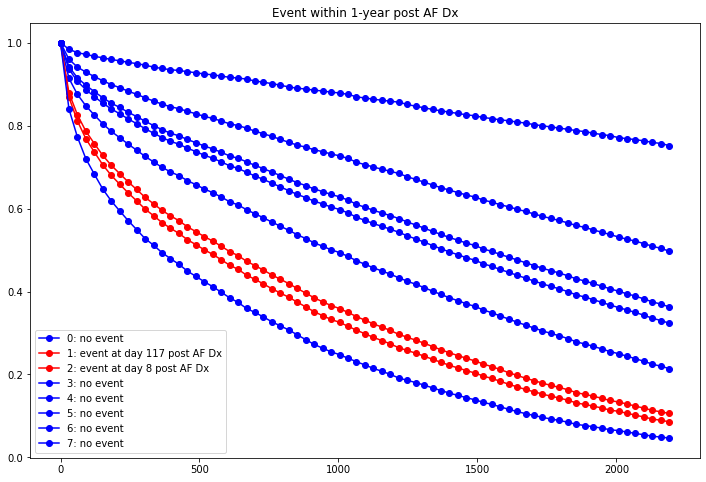

In [131]:
NYRS=1

query_time_endpoint = NYRS*365 # risk prediction at the nth date

nsamples=Samples[ev].shape[0]

plt.figure( figsize=(12, 8 ) )
for q in range( nsamples ):

  t=Samples[ev].Time2Event[q]
  if (Samples[ev]['Event?'][q]) and (t < query_time_endpoint):
    lab='%d: event at day %d post AF Dx'% (q,t)
    c='r'
  else: 
    lab='%d: no event' %q
    c='b'
  plt.plot(breaks,np.concatenate(([1], np.cumprod(yp[ q,:]))),'o-', color=c, label=lab )

plt.legend()
plt.title('Event within %d year post AF Dx'%NYRS)


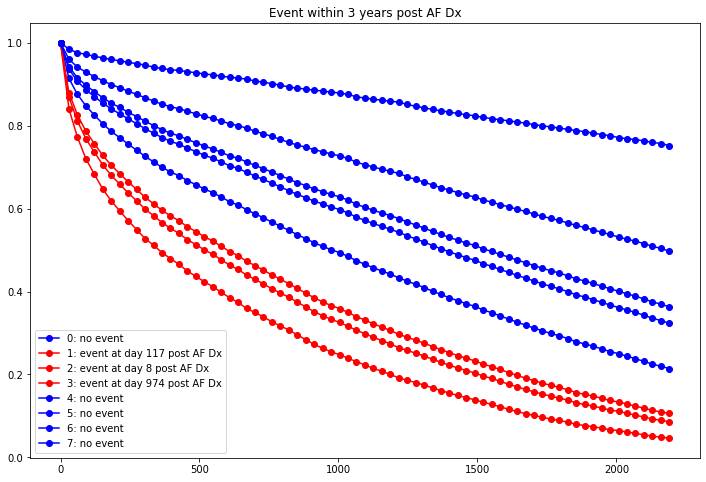

In [133]:
NYRS=3

query_time_endpoint = NYRS*365 # risk prediction at the nth date

nsamples=Samples[ev].shape[0]

plt.figure( figsize=(12, 8 ) )
for q in range( nsamples ):

  t=Samples[ev].Time2Event[q]
  if (Samples[ev]['Event?'][q]) and (t < query_time_endpoint):
    lab='%d: event at day %d post AF Dx'% (q,t)
    c='r'
  else: 
    lab='%d: no event' %q
    c='b'
  plt.plot(breaks,np.concatenate(([1], np.cumprod(yp[ q,:]))),'o-', color=c, label=lab )

plt.title('Event within %d years post AF Dx'%NYRS)
plt.legend()

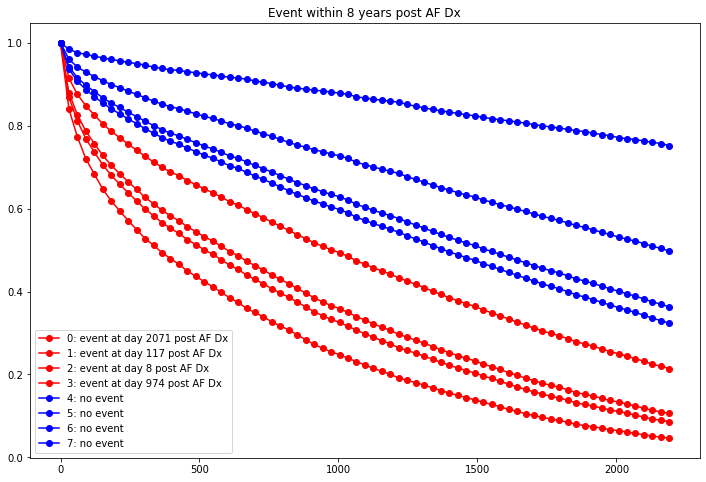

In [134]:
NYRS=8

query_time_endpoint = NYRS*365 # risk prediction at the nth date

nsamples=Samples[ev].shape[0]

plt.figure( figsize=(12, 8 ) )
for q in range( nsamples ):

  t=Samples[ev].Time2Event[q]
  if (Samples[ev]['Event?'][q]) and (t < query_time_endpoint):
    lab='%d: event at day %d post AF Dx'% (q,t)
    c='r'
  else: 
    lab='%d: no event' %q
    c='b'
  plt.plot(breaks,np.concatenate(([1], np.cumprod(yp[ q,:]))),'o-', color=c, label=lab )

plt.title('Event within %d years post AF Dx'%NYRS)
plt.legend()